In [14]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [15]:
# Libraries
import tensorflow as tf
import cv2, os
from PIL import Image, ImageOps
import numpy as np
from itertools import repeat

def load_images_from_folder(folder, size):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        fit_and_resized_image = ImageOps.fit(img, size, Image.ANTIALIAS)
        img = np.array(fit_and_resized_image)
        img = img[...,:3]
        if img is not None:
            images.append(img)
    return images

def load_images_from_directory(path, size):
    paths = os.listdir(path)
    paths.remove('.DS_Store')
    x = []; y = []; lbl_dict = {}; lbl_num = 0; counts = []
    for folder in paths:
        images = load_images_from_folder(os.path.join(path, folder), size)
        lbl_nums = list(repeat(lbl_num, len(images)))
        x.extend(images)
        y.extend(lbl_nums)
        counts.append(len(lbl_nums))
        lbl_dict[folder] = lbl_num
        lbl_num += 1
    return (x, y, lbl_dict, counts)

In [17]:
TRAIN_DIR = '/Users/sarah/Documents/RC/Rock Classifier 4/validate'
TEST_DIR = '/Users/sarah/Documents/RC/Rock Classifier 4/train'

IMAGE_SIZE = (100, 100)

x_tr = []; y_tr = []
x_tst= []; y_tst = []

x_tr, y_tr, labels, counts = load_images_from_directory(TRAIN_DIR, IMAGE_SIZE)

print('Train shape:', np.shape(x_tr))
print(list(labels.keys()), counts)
    
x_tst, y_tst, labels, counts = load_images_from_directory(TEST_DIR, IMAGE_SIZE)

print('Test shape:', np.shape(x_tst))
print(list(labels.keys()), counts)

Train shape: (45, 100, 100, 3)
['Granodiorite', 'Granite', 'Diorite', 'Gabbro'] [13, 13, 8, 11]
Test shape: (36, 100, 100, 3)
['Granodiorite', 'Granite', 'Diorite', 'Gabbro'] [12, 6, 8, 10]


In [16]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

In [18]:
x = x_tr
y = y_tr
x.extend(x_tst)
y.extend(y_tst)

In [19]:
type(x)

list

In [20]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img in label_dataframe:
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(x)

In [21]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

Feature matrix shape is:  (81, 30000)
PCA matrix shape is:  (81, 30000)


In [23]:
X = pd.DataFrame(bees_pca)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    18
3    14
0    14
2    10
dtype: int64

In [24]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [25]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.32


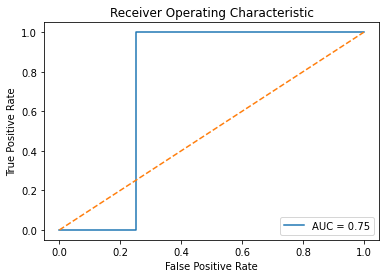

In [26]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');